In [1]:
import pandas as pd

import torch 
import pandas as pd
import numpy as np
from amlvae.models.VAE import VAE

from matplotlib import pyplot as plt
import gseapy as gp
import umap 
import seaborn as sbn

from sklearn.cluster import OPTICS, DBSCAN, HDBSCAN

from amlvae.models.MLP import MLP


In [2]:
tcga_df = pd.read_excel('/mnt/c/Users/natha/Downloads/TCGA.LAML.cNMF-clustering.20140820.xlsx', sheet_name='mRNA-seq (n=179)')
gdc2tcga = pd.read_csv('../../data/tcga_sample_mapping.csv').rename({'patient_barcode':'sample.id'}, axis=1)
tcga_df = tcga_df.merge(gdc2tcga, on='sample.id', how='left')
tcga_df.head()

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,heatmap.order,sample.id,cluster,silhouette.width,gdc_id
0,1,TCGA-AB-2912,7,0.973557,f77c2ed0-9fa9-406d-baff-33f8c5d62f79
1,2,TCGA-AB-2971,7,0.978528,7241b7bc-630f-4821-a4d1-aa7edfcd2b98
2,3,TCGA-AB-2866,7,0.987822,be5015ff-cd90-4c63-a958-a222ca6d8809
3,4,TCGA-AB-3005,7,0.992609,NaN
4,5,TCGA-AB-2965,7,0.996841,6297e246-48f5-4f6e-b3b2-6ef6aa384120


In [3]:
model = torch.load('/home/teddy/local/AMLVAE/output/var_preproc5000_TPM_5-1-25/vae.pt', weights_only=False).eval()


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

VAE(
  (encoder): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=5000, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0, inplace=False)
      (4): Linear(in_features=512, out_features=64, bias=True)
    )
  )
  (decoder): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=5000, bias=True)
    )
  )
)

In [5]:
expr = pd.read_csv('../data/aml_expr.csv')
X = expr.iloc[:, 1:].values

In [ ]:
expr = pd.read_csv('../data/aml_expr.csv')
X = expr.iloc[:, 1:].values
z = model.encode(torch.tensor(X, dtype=torch.float32).to(device))[0].cpu().detach().numpy()

In [7]:
reducer = umap.UMAP() 
u = reducer.fit_transform(z, metric='cosine', num_neighbors=25, min_dist=1.0)

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
res = pd.DataFrame(u, columns=['u1', 'u2']).assign(gdc_id=expr.iloc[:, 0].values)
res = res.merge(tcga_df, on='gdc_id', how='left')
res = res.fillna('NA')
res.head()

,u1,u2,gdc_id,heatmap.order,sample.id,cluster,silhouette.width
0,7.344070,5.750397,001454b2-aff9-4659-85a6-73fb8092589a,NA,NA,NA,NA
1,8.360807,5.917034,002cacd9-c03b-4526-a380-0701f41c4a9e,NA,NA,NA,NA
2,9.312391,3.548255,006e5777-2603-4db7-a1d6-8c8085c5e3e5,NA,NA,NA,NA
3,10.382481,7.625426,00870f33-cab3-4c23-bd0d-8903a5a9789e,NA,NA,NA,NA
4,5.987589,5.485111,00b535f6-064a-4dcf-ab14-387a54eedeee,NA,NA,NA,NA


In [9]:
clin = pd.read_csv('../../data/beataml_clinical_for_inputs.csv')
res = res.merge(clin, on='gdc_id', how='left')
res.head()

,u1,u2,gdc_id,heatmap.order,sample.id,cluster,silhouette.width,patientId,labId,dbgap_subject_id,...,dxAtSpecimenAcquisition,isTransformed,priorMDS,FLT3-ITD,allelic_ratio,NPM1,RUNX1,ASXL1,TP53,ELN2017
0,7.344070,5.750397,001454b2-aff9-4659-85a6-73fb8092589a,NA,NA,NA,NA,825.0,12-00294,2518.0,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,positive,1.000000,negative,NaN,NaN,NaN,Adverse
1,8.360807,5.917034,002cacd9-c03b-4526-a380-0701f41c4a9e,NA,NA,NA,NA,1675.0,14-00488,2354.0,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,positive,0.449275,negative,RUNX1 (p.Q262*; 72.4%),NaN,NaN,Adverse
2,9.312391,3.548255,006e5777-2603-4db7-a1d6-8c8085c5e3e5,NA,NA,NA,NA,4930.0,18-00173,2657.0,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,negative,0.000000,positive,NaN,NaN,NaN,Favorable
3,10.382481,7.625426,00870f33-cab3-4c23-bd0d-8903a5a9789e,NA,NA,NA,NA,2205.0,15-00559,2064.0,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,negative,0.000000,negative,NaN,NaN,NaN,NonInitial
4,5.987589,5.485111,00b535f6-064a-4dcf-ab14-387a54eedeee,NA,NA,NA,NA,4028.0,16-00810,2414.0,...,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,FALSE,n,negative,0.000000,positive,NaN,NaN,NaN,Favorable


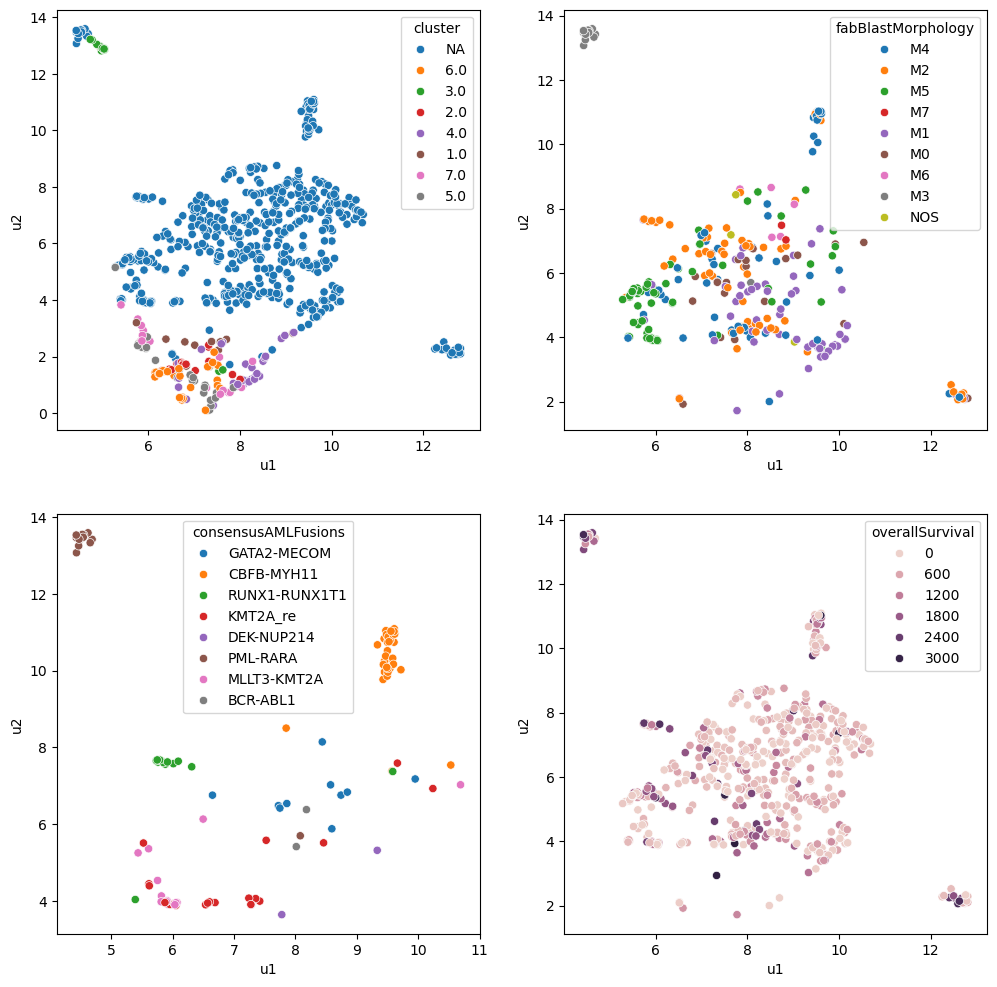

In [10]:
f, axes = plt.subplots(2,2, figsize=(12, 12))

sbn.scatterplot(data=res, x='u1', y='u2', hue='cluster', alpha=1., palette='tab10', ax=axes[0, 0])
sbn.scatterplot(data=res, x='u1', y='u2', hue='fabBlastMorphology', alpha=1., palette='tab10', ax=axes[0, 1])
sbn.scatterplot(data=res, x='u1', y='u2', hue='consensusAMLFusions', alpha=1., palette='tab10', ax=axes[1, 0])
sbn.scatterplot(data=res, x='u1', y='u2', hue='overallSurvival', alpha=1., ax=axes[1, 1])
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()